## Application à l'études des données internationales
Dans ce notebook, nous faisons une étude semblable à celle menée sur la France, en construisant les features explicitées dans le notebook France pour chaque pays de la liste proposée.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
HSUP = pd.read_csv('EXIOBASE_3_3_18_htot_2011\MR_HSUP_2011_v3_3_18.csv')
HUSE = pd.read_csv('EXIOBASE_3_3_18_htot_2011\MR_HUSE_2011_v3_3_18.csv')

dry_matter_coeffs_HSUTs = pd.read_excel('EXIOBASE_3_3_18_htot_2011\MR_HSUTs_2011_v3_3_18_dry_matter_coeff.xlsx')
FD_HSUTs = pd.read_csv('EXIOBASE_3_3_18_htot_2011\MR_HSUTs_2011_v3_3_18_FD.csv')
stock_to_waste_HSUTs = pd.read_csv('EXIOBASE_3_3_18_htot_2011\MR_HSUTs_2011_v3_3_18_stock_to_waste.csv')
waste_coefficients_HSUTs = pd.read_excel('EXIOBASE_3_3_18_htot_2011\MR_HSUTs_2011_v3_3_18_waste_coefficients.xlsx')

classifications_excel = pd.ExcelFile('EXIOBASE_3_3_18_htot_2011\Classifications_v_3_3_18.xlsx')
classifications = pd.read_excel(classifications_excel, sheet_name = 'Country')

extensions_HSUTs = {}
extension_excel = pd.ExcelFile('EXIOBASE_3_3_18_htot_2011\MR_HSUTs_2011_v3_3_18_extensions.xlsx')
for sheetname in extension_excel.sheet_names:
    extensions_HSUTs[sheetname] = pd.read_excel(extension_excel, sheet_name= sheetname)

In [ ]:
#liste des pays pris en considérations
country_list = classifications['Country code']
country_list = country_list[country_list != 'TW']
cat_list = ['Agriculture', 'fossil sources', 'Wood and fossils fuels', 'Matieres', 'petrole derivés', 'Mineral products', 'Metals', 'Machinery and devices',
 'Elec and gaz', 'Construction','transport', 'services', 'waste', 'Public', 'culture', 'other' ]
cat_sep = {
    'Agriculture':['01'], 'fossil sources' : ['10', '11' , '12'], 'Matieres' : ['14', '15', '16', '17', '18', '19'], 'Wood and fossils fuels': ['23.', '22', '21'], 'petrole derivés': ['24'], 'Mineral products':['25', '26'],
    'Metals': ['27'], 'Machinery and devices':['28', '3'], 'Elec and gaz' : ['40.'], 'Construction':['41', '42', '43', '44', '45'],
     'services':['5', '62', '63', '64', '65', '66', '67', '71', '72', '73', '74'],
    'transport':['60', '61'], 'Public':['75', '8', '91'], 'waste':['90'], 'culture':['92'], 'other':['93', '95', '99']
}

columns = []
for cat in cat_list:
    for country in country_list:
        columns.append(country + '_' + cat +'act')
rows = []
for cat in cat_list:
    for country in country_list:
        rows.append(country + '_' + cat +'product')


In [ ]:
#this function will search in a vectorize way if a character is in a chain, it will enables us to select the columns we want in the dataFrames
def search_character(character, chaine):  
    return (character in chaine) or ('Unnamed' in chaine)
search_character = np.vectorize(search_character)

In [ ]:
liste_features = ['use_internal_mass', 'use_external_mass_in', 'use_external_mass_out', 'use_internal_money', 'use_external_money_in', 'use_external_money_out',
                    'use_internal_energy', 'use_external_energy_in', 'use_external_energy_out',
                  'supply_internal_mass', 'supply_external_mass_in', 'supply_external_mass_out', 'supply_internal_money', 'supply_external_money_in', 'supply_external_money_out',
                    'supply_internal_energy', 'supply_external_energy_in', 'supply_external_energy_out',   
                    'waste_total_amount'  , 'waste_proportion_reused', 'resource' , 'GES'] 

df_features = pd.DataFrame(index = liste_features)


In [ ]:
def construct_extension(country):
    extensions_HSUTs_country = {}
    for key in extensions_HSUTs.keys():
        columns = extensions_HSUTs[key].columns
        new_columns = extensions_HSUTs[key].iloc[0]
        new_columns[0] = 'resource'    
        new_columns[1] = 'unit'
        extensions_HSUTs_country[key] = extensions_HSUTs[key][columns[search_character(country,columns)]]
        new_columns = extensions_HSUTs_country[key].iloc[0]
        extensions_HSUTs_country[key].drop(0)
        extensions_HSUTs_country[key].columns = new_columns
    return extensions_HSUTs_country
    


In [ ]:
def construct_feature_resource(extensions):
    #loading of the data
    resource_act = extensions['resource_act']
    resource_FD = extensions['resource_FD']

    

    resource_FR = resource_act
    resource_FR = resource_FR.join(resource_FD.iloc[:, 3:])

    resource_FR['Total'] = resource_FR.iloc[3:, 2:].sum(axis = 1)
    feature_resource = resource_FR['Total'].fillna(0).sum()
    return feature_resource

In [ ]:
def construct_feature_GES(extensions):

    gaz_list = ['Carbon dioxide, fossil','Carbon dioxide, biogenic', 'CH4', 'N2O', 'HFCs', 'PFCs', 'SF6', 'CFCs','HCFCs', ]
    PRG_list = [1,1, 25, 298, 2000, 9000,23500 , 8000, 700]

    emiss_act = extensions['Emiss_act']
    emiss_unregis_act = extensions['Emis_unreg_w_act']

    emiss_FD = extensions['Emiss_FD']
    emiss_unregis_FD = extensions['Emis_unreg_w_FD']
    data_PRG_act = pd.DataFrame(PRG_list, index = gaz_list, columns= ['PRG'])
    emiss_act.set_index(emiss_act['resource'], inplace=True)
    emiss_act.drop(['resource'], axis = 1, inplace = True)
    data_GES_act = emiss_act.join(data_PRG_act, how = 'inner')
    emissisions_GES_act  = pd.DataFrame(data_GES_act.iloc[:,3:-1].sum(axis = 1), columns = ['emissions_act'])
    emissisions_GES_act['PRG_act'] = data_GES_act['PRG']
    emissisions_GES_act['impact_act'] = emissisions_GES_act['emissions_act'] * emissisions_GES_act['PRG_act']

    data_PRG_unregis_act = pd.DataFrame(PRG_list, index = gaz_list, columns= ['PRG'])
    emiss_unregis_act.set_index(emiss_unregis_act['resource'], inplace=True)
    emiss_unregis_act.drop(['resource'], axis = 1, inplace = True)
    data_GES_unregis_act = emiss_unregis_act.join(data_PRG_unregis_act, how = 'inner')
    emissisions_GES_unregis_act  = pd.DataFrame(data_GES_unregis_act.iloc[:,3:-1].sum(axis = 1), columns = ['emissions_unreg_act'])
    emissisions_GES_unregis_act['PRG_unreg_act'] = data_GES_unregis_act['PRG']
    emissisions_GES_unregis_act['impact_unreg_act'] = emissisions_GES_unregis_act['emissions_unreg_act'] * emissisions_GES_unregis_act['PRG_unreg_act']



    data_PRG_FD = pd.DataFrame(PRG_list, index = gaz_list, columns= ['PRG'])
    emiss_FD.set_index(emiss_FD['resource'], inplace=True)
    emiss_FD.drop(['resource'], axis = 1, inplace = True)
    data_GES_FD = emiss_FD.join(data_PRG_FD, how = 'inner')
    emissisions_GES_FD  = pd.DataFrame(data_GES_FD.iloc[:,3:-1].sum(axis = 1), columns = ['emissions_FD'])
    emissisions_GES_FD['PRG_FD'] = data_GES_FD['PRG']
    emissisions_GES_FD['impact_FD'] = emissisions_GES_FD['emissions_FD'] * emissisions_GES_FD['PRG_FD']

    data_PRG_unregis_FD = pd.DataFrame(PRG_list, index = gaz_list, columns= ['PRG'])
    emiss_unregis_FD.set_index(emiss_unregis_FD['resource'], inplace=True)
    emiss_unregis_FD.drop(['resource'], axis = 1, inplace = True)
    data_GES_unregis_FD = emiss_unregis_FD.join(data_PRG_unregis_FD, how = 'inner')
    emissisions_GES_unregis_FD  = pd.DataFrame(data_GES_unregis_FD.iloc[:,3:-1].sum(axis = 1), columns = ['emissions_unreg_FD'])
    emissisions_GES_unregis_FD['PRG_unreg_FD'] = data_GES_unregis_FD['PRG']
    emissisions_GES_unregis_FD['impact_unreg_FD'] = emissisions_GES_unregis_FD['emissions_unreg_FD'] * emissisions_GES_unregis_FD['PRG_unreg_FD']



    



    emissions_FR = emissisions_GES_act.join(emissisions_GES_unregis_act, how = 'right')
    emissions_FR = emissions_FR.join(emissisions_GES_FD, how = 'right' )
    emissions_FR = emissions_FR.join(emissisions_GES_unregis_FD, how = 'right')
    emissions_FR['PRG'] = emissions_FR['PRG_act']
    emissions_FR = emissions_FR[['PRG','impact_act', 'impact_unreg_act', 'impact_FD', 'impact_unreg_FD']]

    emissions_FR['Total'] = emissions_FR.iloc[:,1:].sum(axis = 1)
    feature_GES = emissions_FR['Total'].sum()
    return feature_GES


In [ ]:
def construct_features_waste(extensions, HUSE, country):

    
    waste_supply_act_FR = extensions['waste_sup_act']
    waste_supply_act_FR['Total'] = waste_supply_act_FR.iloc[:,2:].sum(axis = 1)
    waste_supply_act_FR = waste_supply_act_FR.iloc[3:,:]
    waste_supply_act_FR['cat'] = 'act'

    waste_supply_FD_FR = extensions['waste_sup_FD']
    waste_supply_FD_FR['Total'] = waste_supply_FD_FR.iloc[:,2:].sum(axis = 1)
    waste_supply_FD_FR = waste_supply_FD_FR.iloc[3:,:]
    waste_supply_FD_FR['cat'] = 'FD'

    waste_from_stock_FR = extensions['waste_from_stock']
    waste_from_stock_FR['Total'] = waste_from_stock_FR.iloc[:,2:].sum(axis = 1)
    waste_from_stock_FR = waste_from_stock_FR.iloc[3:,:]
    waste_from_stock_FR['cat'] = 'stock'


    waste_use_FR_act = extensions['waste_use_act']

    Waste_used_FR = waste_use_FR_act.iloc[:,search_character('w',waste_use_FR_act.loc[1].astype(str))].sum(axis = 1)

    waste_resume_FR = pd.DataFrame()
    waste_resume_FR['resource'] = waste_supply_act_FR['resource']
    waste_resume_FR['Total_act'] =  waste_supply_act_FR['Total']
    waste_resume_FR['Total_FD'] =  waste_supply_FD_FR['Total']
    waste_resume_FR['Total_stock'] =  waste_from_stock_FR['Total']
    waste_resume_FR['Total_used'] = Waste_used_FR
    waste_resume_FR['Total'] = waste_resume_FR['Total_act']  + waste_resume_FR['Total_stock']   + waste_resume_FR['Total_FD']

    #Récupération de features sur les déchets
    proportion_consommateur_industrie = waste_resume_FR['Total_FD'].sum() / waste_resume_FR['Total_act'].sum()

    feature_waste_total_amount = waste_resume_FR.Total.sum()
    feature_waste_proportion_reused = waste_resume_FR.Total_used.sum() / feature_waste_total_amount
   
    return (feature_waste_total_amount, feature_waste_proportion_reused)

            



In [ ]:
def construct_feature_eco(the_country, HSUP_cat_mass, HSUP_cat_money, HSUP_cat_energy,  HUSE_cat_mass, HUSE_cat_money, HUSE_cat_energy):     

    internal_supply_flux_money= HSUP_cat_money.loc[:,search_character(the_country, HSUP_cat_money.columns)].sum(axis = 1).loc[search_character(the_country, HSUP_cat_money.index)]
    external_supply_flux_in_money = HSUP_cat_money.sum(axis = 1).loc[search_character(the_country, HSUP_cat_money.index)] - internal_supply_flux_money
    external_supply_flux_out_money = pd.DataFrame(index = HSUP_cat_energy.index[search_character(the_country,HSUP_cat_energy.index)], columns = HSUP_cat_money.loc[:,search_character(the_country, HSUP_cat_money.columns)].columns )
    data = HSUP_cat_money.loc[:,search_character(the_country, HSUP_cat_money.columns)]
    for cat in cat_list:
        mask = search_character(cat, HSUP_cat_money.index)
        df = data.loc[mask]
        external_supply_flux_out_money.loc[the_country + '_' + cat + 'product'] = df.sum(axis = 0) 
    external_supply_flux_out_money = external_supply_flux_out_money.fillna(0).sum(axis = 1) - internal_supply_flux_money


    internal_supply_flux_mass= HSUP_cat_mass.loc[:,search_character(the_country, HSUP_cat_mass.columns)].sum(axis = 1).loc[search_character(the_country, HSUP_cat_mass.index)]
    external_supply_flux_in_mass = HSUP_cat_mass.sum(axis = 1).loc[search_character(the_country, HSUP_cat_mass.index)] - internal_supply_flux_mass
    external_supply_flux_out_mass = pd.DataFrame(index = HSUP_cat_energy.index[search_character(the_country,HSUP_cat_energy.index)], columns = HSUP_cat_mass.loc[:,search_character(the_country, HSUP_cat_mass.columns)].columns )
    data = HSUP_cat_mass.loc[:,search_character(the_country, HSUP_cat_mass.columns)]
    for cat in cat_list:
        mask = search_character(cat, HSUP_cat_mass.index)
        df = data.loc[mask]
        external_supply_flux_out_mass.loc[the_country + '_' + cat + 'product'] = df.sum(axis = 0) 
    external_supply_flux_out_mass = external_supply_flux_out_mass.fillna(0).sum(axis = 1) - internal_supply_flux_mass

    internal_supply_flux_energy= HSUP_cat_energy.loc[:,search_character(the_country, HSUP_cat_energy.columns)].sum(axis = 1).loc[search_character(the_country, HSUP_cat_energy.index)]
    external_supply_flux_in_energy = HSUP_cat_energy.sum(axis = 1).loc[search_character(the_country, HSUP_cat_energy.index)] - internal_supply_flux_energy
    external_supply_flux_out_energy = pd.DataFrame(index = HSUP_cat_energy.index[search_character(the_country,HSUP_cat_energy.index)], columns = HSUP_cat_energy.loc[:,search_character(the_country, HSUP_cat_energy.columns)].columns )
    data = HSUP_cat_energy.loc[:,search_character(the_country, HSUP_cat_energy.columns)]
    for cat in cat_list:
        mask = search_character(cat, HSUP_cat_energy.index)
        df = data.loc[mask]
        external_supply_flux_out_energy.loc[the_country + '_' + cat + 'product'] = df.sum(axis = 0) 
    external_supply_flux_out_energy = external_supply_flux_out_energy.fillna(0).sum(axis = 1) - internal_supply_flux_energy




                    
                

    internal_use_flux_money= HUSE_cat_money.loc[:,search_character(the_country, HUSE_cat_money.columns)].sum(axis = 1).loc[search_character(the_country, HUSE_cat_money.index)]
    external_use_flux_in_money = HUSE_cat_money.sum(axis = 1).loc[search_character(the_country, HUSE_cat_money.index)] - internal_use_flux_money
    external_use_flux_out_money = pd.DataFrame(index = HUSE_cat_energy.index[search_character(the_country,HUSE_cat_energy.index)], columns = HUSE_cat_money.loc[:,search_character(the_country, HUSE_cat_money.columns)].columns )
    data = HUSE_cat_money.loc[:,search_character(the_country, HUSE_cat_money.columns)]
    for cat in cat_list:
        mask = search_character(cat, HUSE_cat_money.index)
        df = data.loc[mask]
        external_use_flux_out_money.loc[the_country + '_' + cat + 'act'] = df.sum(axis = 0) 
    external_use_flux_out_money = external_use_flux_out_money.fillna(0).sum(axis = 1) - internal_use_flux_money


    internal_use_flux_mass= HUSE_cat_mass.loc[:,search_character(the_country, HUSE_cat_mass.columns)].sum(axis = 1).loc[search_character(the_country, HUSE_cat_mass.index)]
    external_use_flux_in_mass = HUSE_cat_mass.sum(axis = 1).loc[search_character(the_country, HUSE_cat_mass.index)] - internal_use_flux_mass
    external_use_flux_out_mass = pd.DataFrame(index = HUSE_cat_energy.index[search_character(the_country,HUSE_cat_energy.index)], columns = HUSE_cat_mass.loc[:,search_character(the_country, HUSE_cat_mass.columns)].columns )
    data = HUSE_cat_mass.loc[:,search_character(the_country, HUSE_cat_mass.columns)]
    for cat in cat_list:
        mask = search_character(cat, HUSE_cat_mass.index)
        df = data.loc[mask]
        external_use_flux_out_mass.loc[the_country + '_' + cat + 'act'] = df.sum(axis = 0) 
    external_use_flux_out_mass = external_use_flux_out_mass.fillna(0).sum(axis = 1) - internal_use_flux_mass

    internal_use_flux_energy= HUSE_cat_energy.loc[:,search_character(the_country, HUSE_cat_energy.columns)].sum(axis = 1).loc[search_character(the_country, HUSE_cat_energy.index)]
    external_use_flux_in_energy = HUSE_cat_energy.sum(axis = 1).loc[search_character(the_country, HUSE_cat_energy.index)] - internal_use_flux_energy
    external_use_flux_out_energy = pd.DataFrame(index = HUSE_cat_energy.index[search_character(the_country,HUSE_cat_energy.index)], columns = HUSE_cat_energy.loc[:,search_character(the_country, HUSE_cat_energy.columns)].columns )
    data = HUSE_cat_energy.loc[:,search_character(the_country, HUSE_cat_energy.columns)]
    for cat in cat_list:
        mask = search_character(cat, HUSE_cat_energy.index)
        df = data.loc[mask]
        external_use_flux_out_energy.loc[the_country + '_' + cat + 'act'] = df.sum(axis = 0) 
    external_use_flux_out_energy = external_use_flux_out_energy.fillna(0).sum(axis = 1) - internal_use_flux_energy


    
    return([internal_use_flux_mass.sum(), external_use_flux_in_mass.sum(),external_use_flux_out_mass.sum(),internal_use_flux_money.sum(),external_use_flux_in_money.sum(),external_use_flux_out_money.sum(),
        internal_use_flux_energy.sum(),external_use_flux_in_energy.sum(),external_use_flux_out_energy.sum(),
                  internal_supply_flux_mass.sum(), external_supply_flux_in_mass.sum(),external_supply_flux_out_mass.sum(),internal_supply_flux_money.sum(),external_supply_flux_in_money.sum(),external_supply_flux_out_money.sum(),
        internal_supply_flux_energy.sum(),external_supply_flux_in_energy.sum(),external_supply_flux_out_energy.sum()])




                

                    
                



                
    

In [ ]:
def construire_data_sep_USE(HUSE):
    
    HUSE_cat_mass_c = pd.DataFrame(columns = HUSE.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HUSE_mass = HUSE[search_character('tonnes', HUSE['Unnamed: 4'].astype(str))].copy()
    HUSE_mass.iloc[:, 5:] = HUSE_mass.iloc[:, 5:].astype(float)
    for k,act in enumerate(HUSE_mass['Unnamed: 2']):  
        print(k)
        country = HUSE_mass['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HUSE_cat_mass_c[country + '_' + cat +'product'] = HUSE_cat_mass_c[country + '_' + cat +'product'].add(HUSE_mass.iloc[k,5:])

    HUSE_cat_mass_c = HUSE_cat_mass_c.transpose()

    HUSE_cat_mass = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HUSE_mass.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HUSE[countries][1]:
                        HUSE_cat_mass[country + '_' + cat +'act'] = HUSE_cat_mass_c[countries] +HUSE_cat_mass[country + '_' + cat +'act']





    HUSE_cat_money_c = pd.DataFrame(columns = HUSE.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HUSE_money = HUSE[search_character('Meuro', HUSE['Unnamed: 4'].astype(str))].copy()
    HUSE_money.iloc[:, 5:] = HUSE_money.iloc[:, 5:].astype(float)
    for k,act in enumerate(HUSE_money['Unnamed: 2']):  
        print(k)
        country = HUSE_money['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HUSE_cat_money_c[country + '_' + cat +'product'] = HUSE_cat_money_c[country + '_' + cat +'product'].add(HUSE_money.iloc[k,5:])

    HUSE_cat_money_c = HUSE_cat_money_c.transpose()

    HUSE_cat_money = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HUSE_money.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HUSE[countries][1]:
                        HUSE_cat_money[country + '_' + cat +'act'] = HUSE_cat_money_c[countries] +HUSE_cat_money[country + '_' + cat +'act']



    HUSE_cat_energy_c = pd.DataFrame(columns = HUSE.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HUSE_energy = HUSE[search_character('TJ', HUSE['Unnamed: 4'].astype(str))].copy()
    HUSE_energy.iloc[:, 5:] = HUSE_energy.iloc[:, 5:].astype(float)
    for k,act in enumerate(HUSE_energy['Unnamed: 2']):  
        print(k)
        country = HUSE_energy['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HUSE_cat_energy_c[country + '_' + cat +'product'] = HUSE_cat_energy_c[country + '_' + cat +'product'].add(HUSE_energy.iloc[k,5:])

    HUSE_cat_energy_c = HUSE_cat_energy_c.transpose()

    HUSE_cat_energy = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HUSE_energy.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HUSE[countries][1]:
                        HUSE_cat_energy[country + '_' + cat +'act'] = HUSE_cat_energy_c[countries] +HUSE_cat_energy[country + '_' + cat +'act']




    HUSE_cat_mass = HUSE_cat_mass.transpose()
    HUSE_cat_money = HUSE_cat_money.transpose()
    HUSE_cat_energy = HUSE_cat_energy.transpose()              
    

    return (HUSE_cat_mass, HUSE_cat_money, HUSE_cat_energy)


                        
                    



                    

In [ ]:
def construire_data_sep_SUP(HSUP):
    
    HSUP_cat_mass_c = pd.DataFrame(columns = HSUP.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HSUP_mass = HSUP[search_character('tonnes', HSUP['Unnamed: 4'].astype(str))].copy()
    HSUP_mass.iloc[:, 5:] = HSUP_mass.iloc[:, 5:].astype(float)
    for k,act in enumerate(HSUP_mass['Unnamed: 2']):  
        print(k)
        country = HSUP_mass['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HSUP_cat_mass_c[country + '_' + cat +'product'] = HSUP_cat_mass_c[country + '_' + cat +'product'].add(HSUP_mass.iloc[k,5:])

    HSUP_cat_mass_c = HSUP_cat_mass_c.transpose()

    HSUP_cat_mass = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HSUP_mass.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HSUP[countries][1]:
                        HSUP_cat_mass[country + '_' + cat +'act'] = HSUP_cat_mass_c[countries] +HSUP_cat_mass[country + '_' + cat +'act']





    HSUP_cat_money_c = pd.DataFrame(columns = HSUP.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HSUP_money = HSUP[search_character('Meuro', HSUP['Unnamed: 4'].astype(str))].copy()
    HSUP_money.iloc[:, 5:] = HSUP_money.iloc[:, 5:].astype(float)
    for k,act in enumerate(HSUP_money['Unnamed: 2']):  
        print(k)
        country = HSUP_money['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HSUP_cat_money_c[country + '_' + cat +'product'] = HSUP_cat_money_c[country + '_' + cat +'product'].add(HSUP_money.iloc[k,5:])

    HSUP_cat_money_c = HSUP_cat_money_c.transpose()

    HSUP_cat_money = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HSUP_money.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HSUP[countries][1]:
                        HSUP_cat_money[country + '_' + cat +'act'] = HSUP_cat_money_c[countries] +HSUP_cat_money[country + '_' + cat +'act']



    HSUP_cat_energy_c = pd.DataFrame(columns = HSUP.columns[5:], index = rows, dtype = float).fillna(0).transpose()

    HSUP_energy = HSUP[search_character('TJ', HSUP['Unnamed: 4'].astype(str))].copy()
    HSUP_energy.iloc[:, 5:] = HSUP_energy.iloc[:, 5:].astype(float)
    for k,act in enumerate(HSUP_energy['Unnamed: 2']):  
        print(k)
        country = HSUP_energy['Unnamed: 0'].iloc[k]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in act:
                        HSUP_cat_energy_c[country + '_' + cat +'product'] = HSUP_cat_energy_c[country + '_' + cat +'product'].add(HSUP_energy.iloc[k,5:])

    HSUP_cat_energy_c = HSUP_cat_energy_c.transpose()

    HSUP_cat_energy = pd.DataFrame(index = rows, columns = columns).fillna(0)
    for k,countries in enumerate(HSUP_energy.columns[5:]):  
        print(k)
        country = countries[:2]
        for cat in cat_list:
            for sign in cat_sep[cat]:
                if sign in HSUP[countries][1]:
                        HSUP_cat_energy[country + '_' + cat +'act'] = HSUP_cat_energy_c[countries] +HSUP_cat_energy[country + '_' + cat +'act']


    
    return (HSUP_cat_mass, HSUP_cat_money, HSUP_cat_energy)


                        
                    



                    

In [ ]:
liste_features = ['use_internal_mass', 'use_external_mass_in', 'use_external_mass_out', 'use_internal_money', 'use_external_money_in', 'use_external_money_out',
                    'use_internal_energy', 'use_external_energy_in', 'use_external_energy_out',
                  'supply_internal_mass', 'supply_external_mass_in', 'supply_external_mass_out', 'supply_internal_money', 'supply_external_money_in', 'supply_external_money_out',
                    'supply_internal_energy', 'supply_external_energy_in', 'supply_external_energy_out',   
                    'waste_total_amount'  , 'waste_proportion_reused', 'resource' , 'GES']             
df_features = pd.DataFrame(index = liste_features)

HSUP_cat_mass, HSUP_cat_money, HSUP_cat_energy = construire_data_sep_SUP(HSUP)
HUSE_cat_mass, HUSE_cat_money, HUSE_cat_energy = construire_data_sep_USE(HUSE)
for country in country_list:
    extensions_HSUTs_country = construct_extension(country)
    feature_resource = construct_feature_resource(extensions_HSUTs_country)
    feature_GES = construct_feature_GES(extensions_HSUTs_country)
    print(country)
    feature_waste_total_amount, feature_waste_proportion_reused = construct_features_waste(extensions_HSUTs_country, HUSE, country)
    features_eco = construct_feature_eco(country, HSUP_cat_mass, HSUP_cat_money, HSUP_cat_energy,  HUSE_cat_mass, HUSE_cat_money, HUSE_cat_energy )
    liste_features_country = features_eco + [feature_waste_total_amount]+ [feature_waste_proportion_reused] + [feature_resource] + [feature_GES]
       
    df_features[country] = liste_features_country
    



A présent que la dataFrame des features pour chaque pays est constitués, nous pouvons effectuer des analyses de données. Le volume des données (une cohorte de 50 pays) avec une vingtaine de features, qui sont probablement fortement corrélées (je pense aux features eco notamment)
Mais avant cela, procédons à quelques rapides remarques sur les données

In [215]:
#on copie la liste des features pour être sur de ne pas la modifier par effet de bord
df = df_features.copy()

## Analyse des plus gros émetteurs de GES

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Emissions de GES en equivalent C02 par Pays')

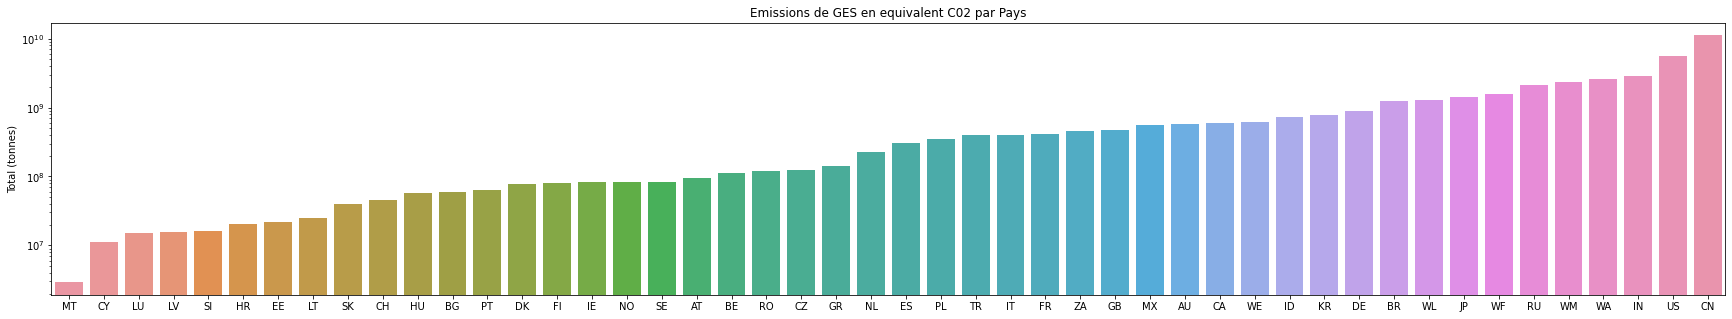

In [218]:
new_index = df.loc['GES'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, df.loc['GES'].sort_values(ascending=True))
ax.set_yscale("log")
ax.set(ylabel = 'Total (tonnes)', title= 'Extraction of resources in France')
ax.set_title('Emissions de GES en equivalent C02 par Pays')

## Remarque:
Les émissions de la Chine sont impressionantes. Si l'on enlève l'échelle logarithmique, on a le graphe suivant

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Emissions de GES en equivalent C02 par Pays')

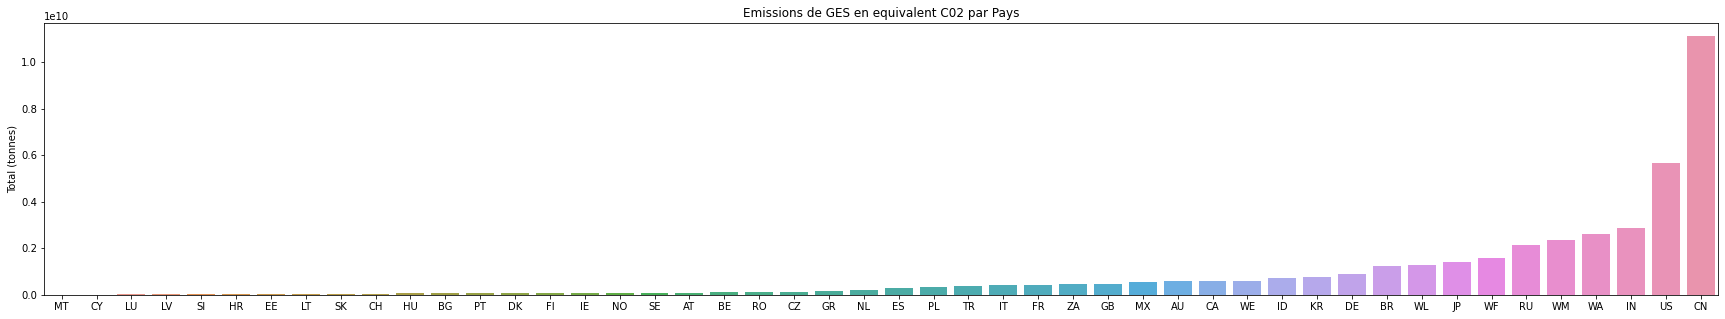

In [220]:
new_index = df.loc['GES'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, df.loc['GES'].sort_values(ascending=True))
ax.set(ylabel = 'Total (tonnes)', title= 'Extraction of resources in France')
ax.set_title('Emissions de GES en equivalent C02 par Pays')

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Emissions de GES en equivalent C02 par les n plus gros pollueurs')

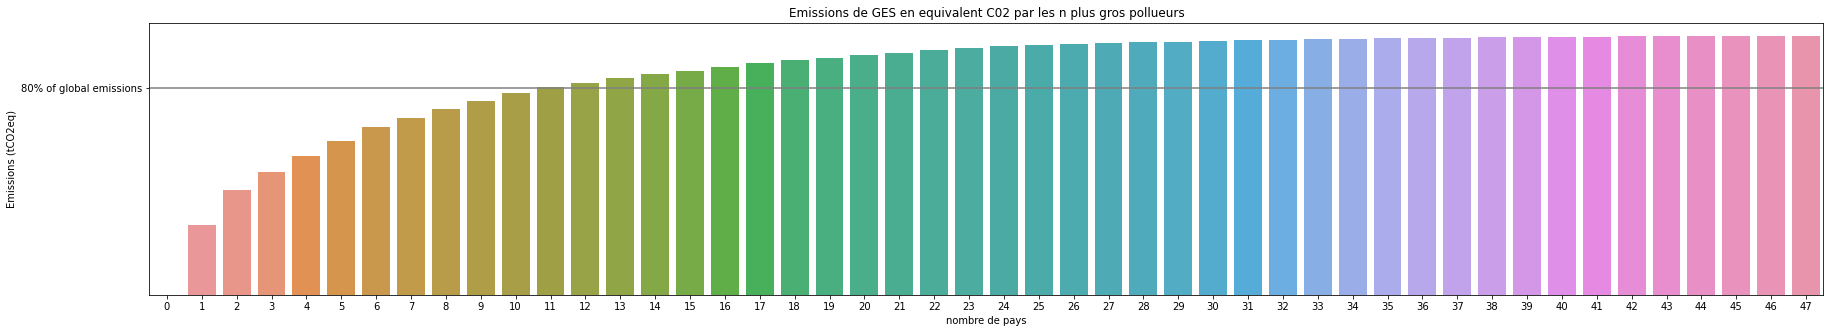

In [221]:
#proportion des émissions par les n plus gros pollueurs.
fig, ax = plt.subplots(figsize=(30, 5))

tab_n = [n for n in  range(len(df.columns))]
seuil = 80/100 * df.loc['GES'].sum()
plt.axhline(y=seuil,color='gray')
emiss = [df.loc['GES'].sort_values(ascending=False)[:n].sum() for n in tab_n]
sn.barplot(tab_n, emiss)
ax.set(ylabel = 'Emissions (tCO2eq)')
ax.set(xlabel = 'nombre de pays' )
ax.set_yticks([seuil], labels= ['80% of global emissions'])

ax.set_title('Emissions de GES en equivalent C02 par les n plus gros pollueurs')

# Bilan
Nous constatons donc que 11 pays sont responsables de 80% des émissions de GES, et nous constatons surtout que ce ce sont les pays développés qui émettent aujourd'hui le plus de CO2.
La loi de Pareto est vérifiée!

## Vérification de la cohérence de certaines features
Au vu de la complexité des données, il se peut qu'il y ait des erreurs dans la construction des features. Il est important de vérifier au moins leur cohérence (ce qui ne suffit malheureusement pas à garantir leur exactitude)

In [222]:
df.loc['rapport_mass'] = df.loc['use_external_mass_out'] / df.loc['use_external_mass_in']
df.loc['rapport_money'] = df.loc['use_external_money_out'] / df.loc['use_external_money_in']


# Intensité économique des pays:
Nous appelerons intensité la somme des flux internes et des flux entrants pour les flux massiques et énergétiques, et nous appellerons richesse la somme des flux monétaires internes et sortants. Ce sont des choix arbitraires, dont j'espère qu'ils permettront de trouver une cohérence dans les résultats.

In [223]:
df.loc['intensity_mass_use'] = df.loc['use_internal_mass'] +df.loc['use_external_mass_in']
df.loc['wealth'] = df.loc['use_internal_money'] +df.loc['supply_external_money_out']
df.loc['intensity_energy_use'] = df.loc['use_internal_energy'] +df.loc['use_external_energy_in']



c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Intensité monétaire des pays')

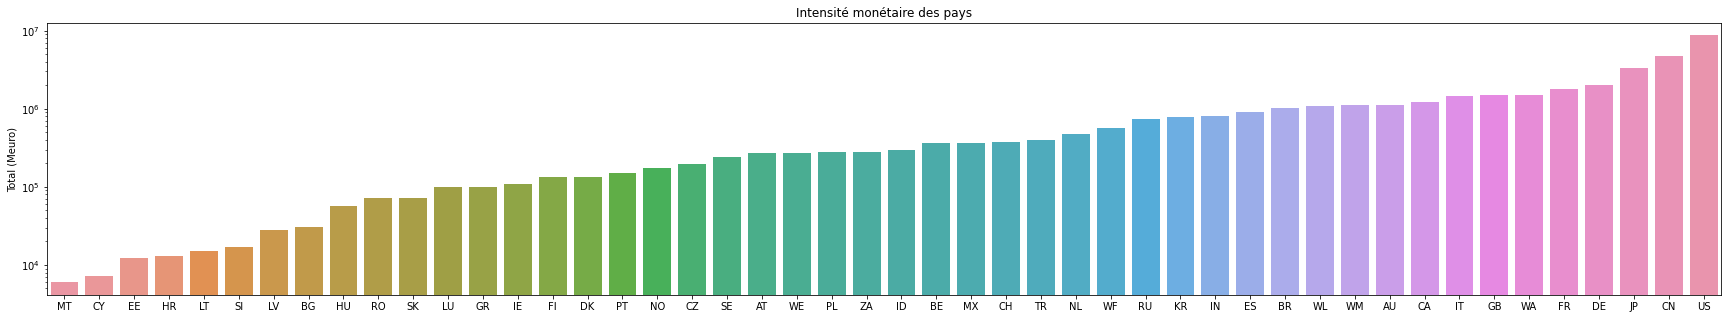

In [224]:
new_index = df.loc['wealth'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, df.loc['wealth'].sort_values(ascending=True))
ax.set_yscale("log")
ax.set(ylabel = 'Total (Meuro)')
ax.set_title('Intensité monétaire des pays')

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Intensité des flux de matière entrant dans pays')

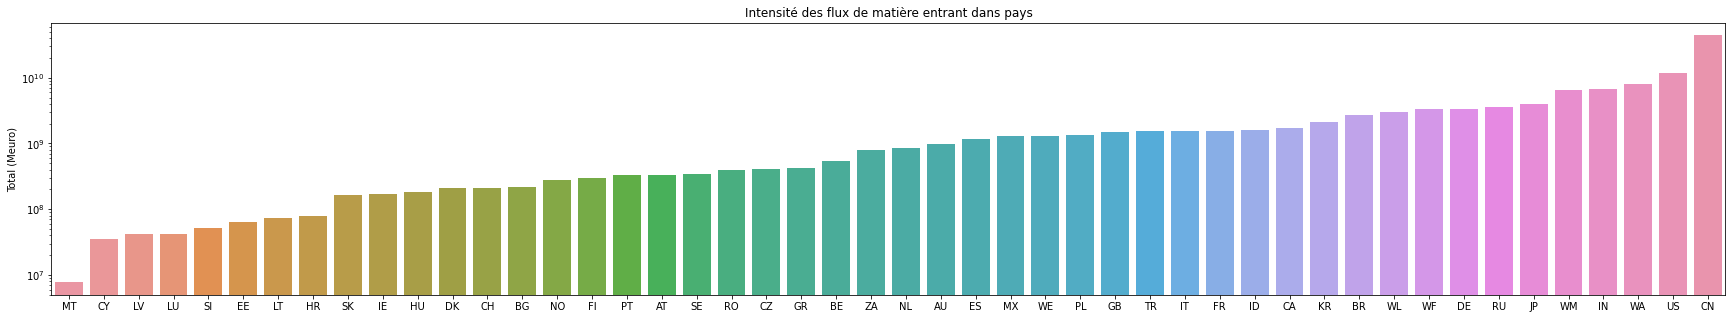

In [177]:
new_index = df.loc['intensity_mass_use'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, df.loc['intensity_mass_use'].sort_values(ascending=True))
ax.set_yscale("log")
ax.set(ylabel = 'Total (Meuro)')
ax.set_title('Intensité des flux de matière entrant dans pays')

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Intensité énergétique des économies des pays')

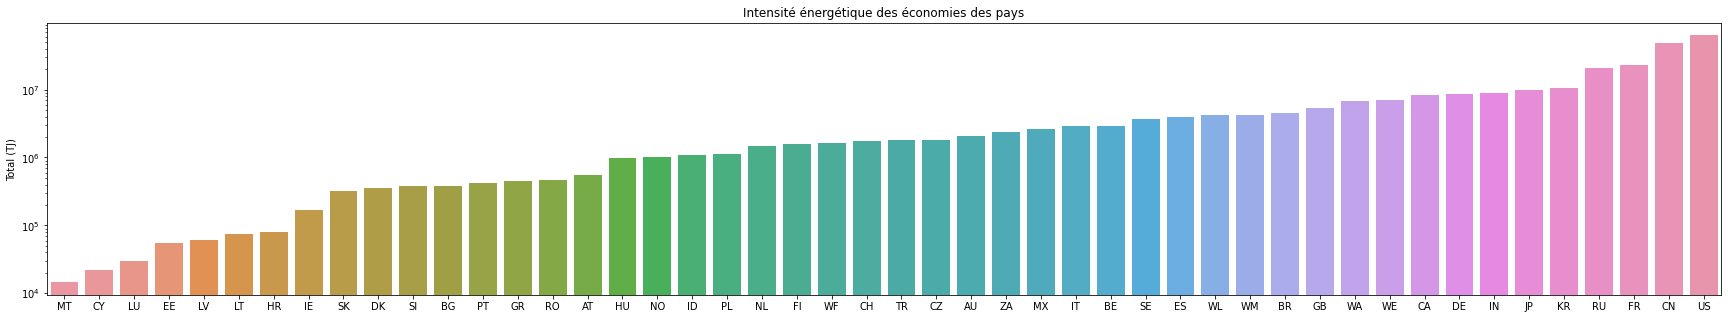

In [178]:
new_index = df.loc['intensity_energy_use'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, df.loc['intensity_energy_use'].sort_values(ascending=True))
ax.set_yscale("log")
ax.set(ylabel = 'Total (TJ)')
ax.set_title('Intensité énergétique des économies des pays')

# Commentaires :
Bien que les valeurs de l'intensité énergétique me paraissent très élevées, on remarque tout de même une certaine cohérence dans les données. 
1) En termes de richesses, on retrouve les pays qui ont des économies fortes (le classement de 2011 a les mêmes 5 premiers pays )
2) Les pays à fort flux de matières et possédant une importante population sont en tête du classement des intensités énergétiques et massiques
On remarque que des pays comme le Luxembourg ou la SUISSE sont très peu intensifs en termes de flux massiques et énergétiques, mais ils montent dans le classement en termes de flux monétaires

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Solde net des investissements direct à l etranger')

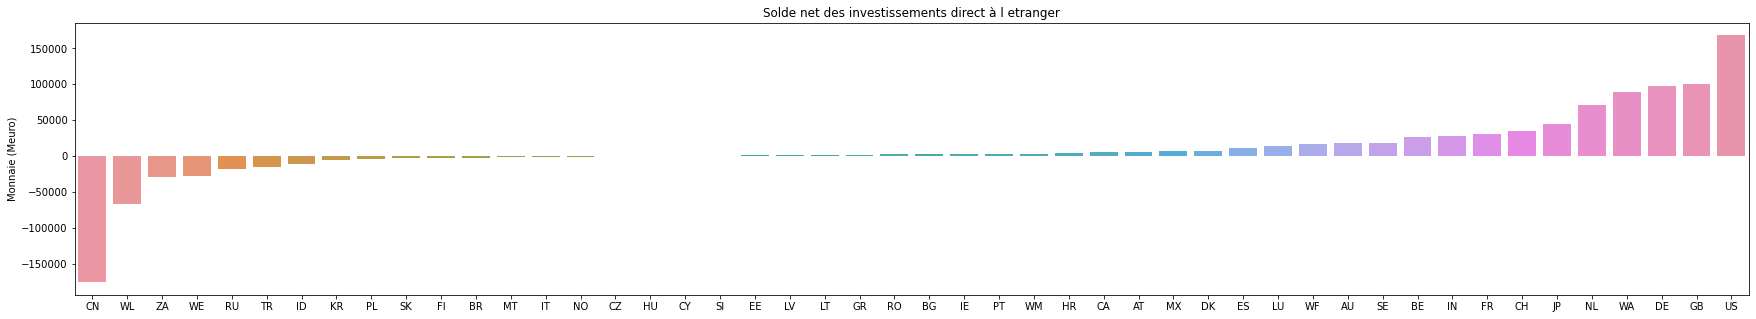

In [192]:
new_index = (df.loc['use_external_money_out']-df.loc['use_external_money_in']).sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, (df.loc['use_external_money_out']-df.loc['use_external_money_in']).sort_values(ascending=True))
ax.set(ylabel = 'Monnaie (Meuro)')
ax.set_title('Solde net des investissements direct à l etranger')

## Commentaire:
On observe bien que la Chine reçoit en 2011 plus d'investissements venant de l'étranger qu'elle n'investit à l'étranger, et inversement, que les US effectuent beaucoup d'IDE.


c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Pays producteurs de déchets')

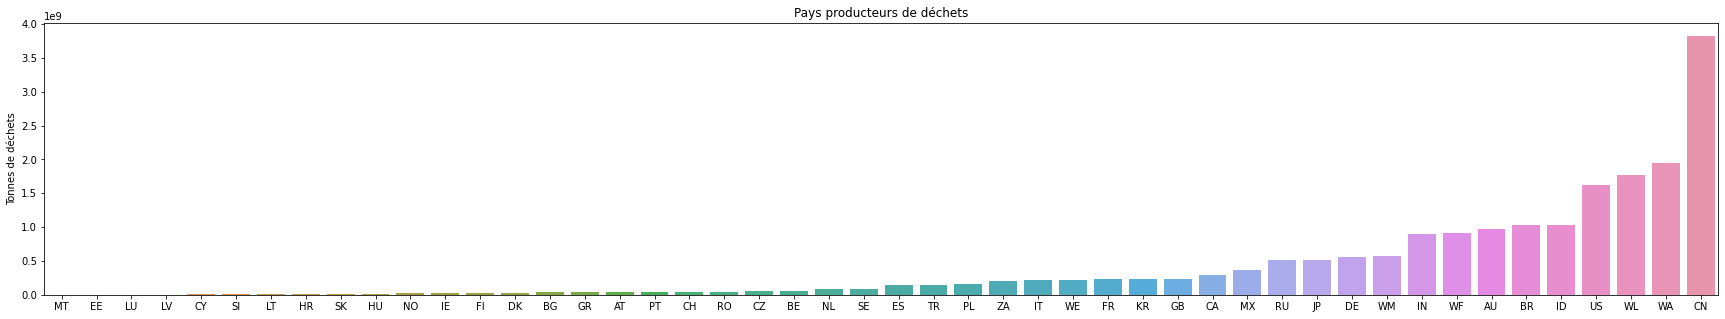

In [197]:
new_index = df.loc['waste_total_amount'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, (df.loc['waste_total_amount']).sort_values(ascending=True))
ax.set(ylabel = 'Tonnes de déchets')
ax.set_title('Pays producteurs de déchets')

c:\Users\marts\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Pays recyclant la plus grande proportion')

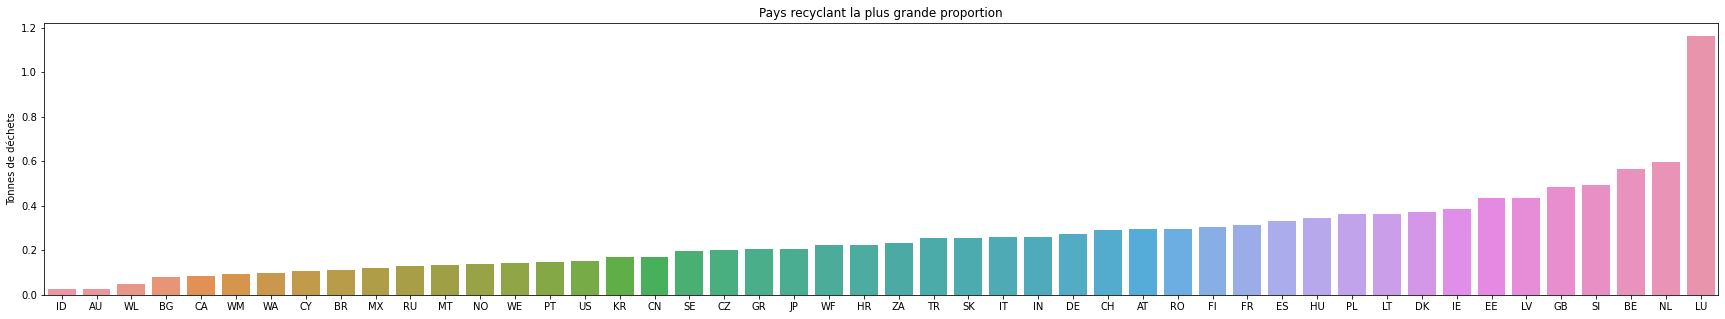

In [199]:
new_index = df.loc['waste_proportion_reused'].sort_values(ascending=True).index
fig, ax = plt.subplots(figsize=(30, 5))
sn.barplot(new_index, (df.loc['waste_proportion_reused']).sort_values(ascending=True))
ax.set(ylabel = 'Tonnes de déchets')
ax.set_title('Pays recyclant la plus grande proportion')

## Commentaire:
Les pays ayant des économies très extractrices et une forte industrie ainsi qu'une forte population produisent beaucoup de déchets.
Et les pays riches européens ont un système efficace de recyclage, contrairement aux pays émergents.

# Conclusion:
Cette rapide étude a montré une certaine cohérence des features. Reste maintenant à voir si l'on peut en tirer quelque chose.

# Petite analyse de données
Nous allons tenter de déterminer quels features jouent un rôle pour expliquer les émissions de gaz à effet de serre d'un pays.
Nous allons pour se faire entrainer des modèles interprétables sur les données, et déterminer les coefficients affectés à chaque feature.
Nous allons essayer avec trois modèles : 
1) Une régression linéaire
2) Une random Forest avec 100 arbres, sans limite de profondeur 
3) Un prédicteur XgBoost, avec des paramètres par défaut

Examinons d'abord les corrélations entre features


In [232]:
#préparation des données
df = df_features.copy()
#standardization
df = df.transpose()
columns = df.columns
mask = columns[df.std() !=0]
df = df[mask]
df = (df - df.mean()) / df.std()


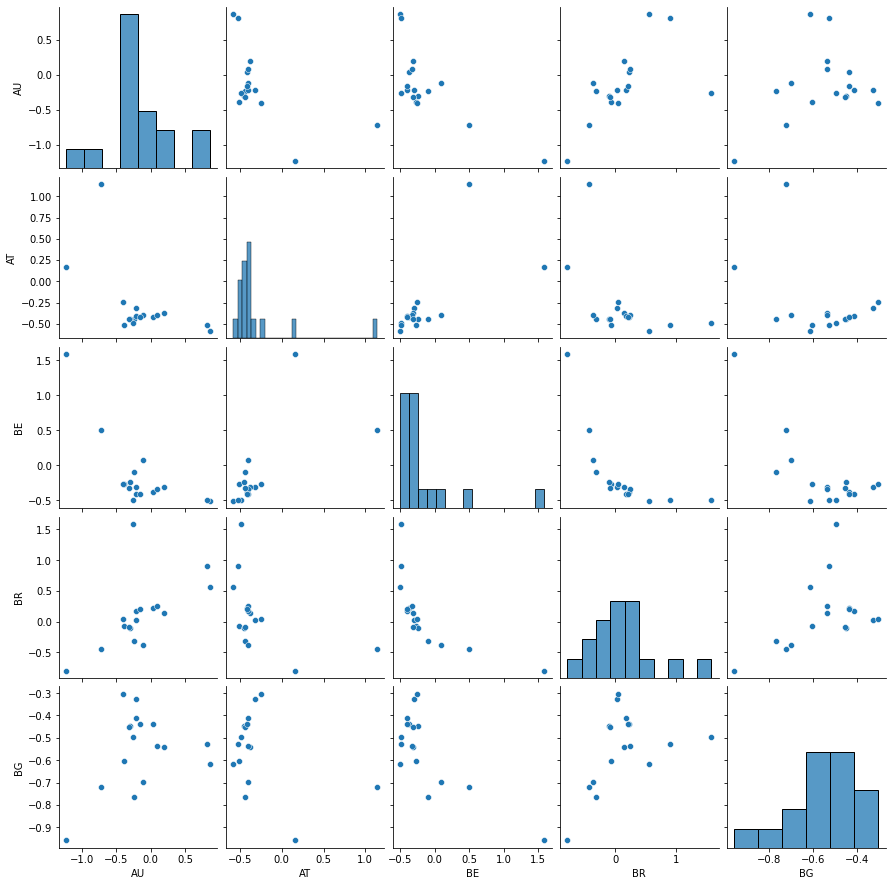

In [201]:
#visualisation of the correlation between the different features
sn.pairplot(df.transpose().iloc[:, :5])

<AxesSubplot:>

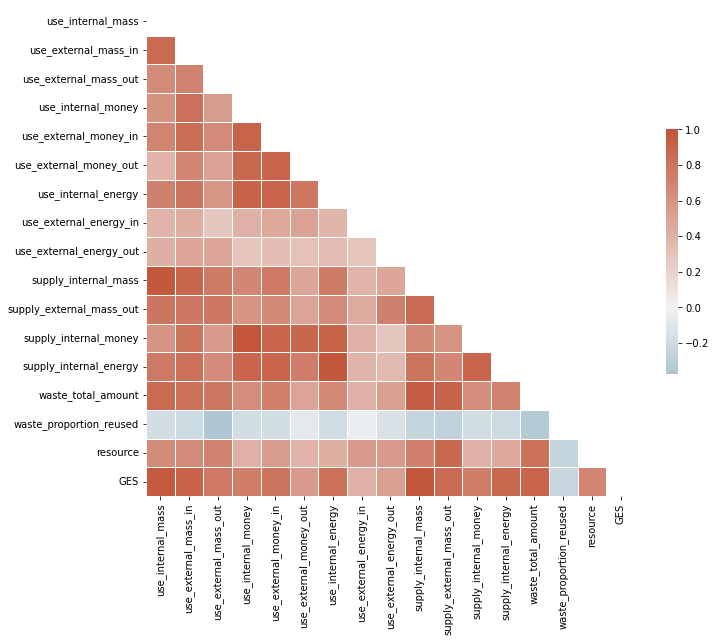

In [226]:
# Compute the correlation matrix
corr = df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sn.diverging_palette(230, 20, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

 #Commentaire
Comme on pouvait s'y attendre, les variables sont fortements corrélées, et notamment les variables USE_... avec les variables SUPPLY_..., ce qui est cohérent.
On pourrait en fait enlever la moitié de ces variables sans trop perdre d'informations (elles disparaitraient lors d'une PCA notamment).



In [227]:
#préparation et séparation des données en un jeu de test et un jeu d'entraînement
x = df[df.columns.drop('GES')]
y = df['GES']
xtrain, xtest, ytrain, ytest =   train_test_split(x, y, test_size=0.1, random_state=1)

In [228]:
model_1_regression = LinearRegression()
model_1_regression.fit(xtrain, ytrain)
y_test_prediction = model_1_regression.predict(xtest)
print(f"Score / training data: {round(model_1_regression.score(xtrain, ytrain)*100, 1)} %")
print(f"Score / test data: {round(model_1_regression.score(xtest, ytest)*100, 1)} %")

Score / training data: 99.9 %
Score / test data: 45.3 %


<AxesSubplot:title={'center':'Feature importance'}, ylabel='Feature Name'>

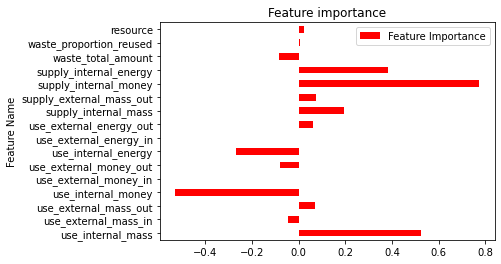

In [229]:
reg = model_1_regression
feat_imp_reg = model_1_regression.coef_
reg_feat_importance = pd.DataFrame(columns=["Feature Name", "Feature Importance"])
reg_feat_importance["Feature Name"] = pd.Series(reg.feature_names_in_)
reg_feat_importance["Feature Importance"] = pd.Series(feat_imp_reg)
reg_feat_importance.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")
 


In [230]:
model_2_rforest = RandomForestRegressor()
model_2_rforest.fit(xtrain, ytrain)
print(f"Score / training data: {round(model_2_rforest.score(xtrain, ytrain)*100, 1)} %")
print(f"Score / test data: {round(model_2_rforest.score(xtest, ytest)*100, 1)} %")

Score / training data: 96.5 %
Score / test data: 87.2 %


<AxesSubplot:title={'center':'Feature importance'}, ylabel='Feature Name'>

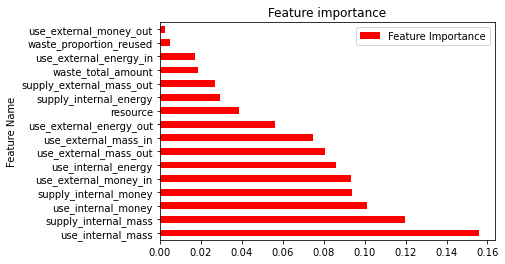

In [231]:
rforest = model_2_rforest
feat_imp = rforest.feature_importances_
df_featimp = pd.DataFrame(feat_imp, columns = {"Feature Importance"})
df_featimp["Feature Name"] = xtrain.columns
df_featimp = df_featimp.sort_values(by="Feature Importance", ascending=False)
df_featimp.plot.barh(y="Feature Importance", x="Feature Name", title="Feature importance", color="red")



In [210]:
model_3_xgboost = XGBRegressor(n_estimators=100, 
                max_depth=5, 
                eta=0.1, 
                subsample=0.7, 
                colsample_bytree=0.8, 
                objective ='reg:squarederror')
model_3_xgboost.fit(xtrain, ytrain)
scores = cross_val_score(model_3_xgboost, xtrain, ytrain,cv=5)
print("Training Data Mean cross-validation score: %.2f" % scores.mean())


Training Data Mean cross-validation score: 0.82


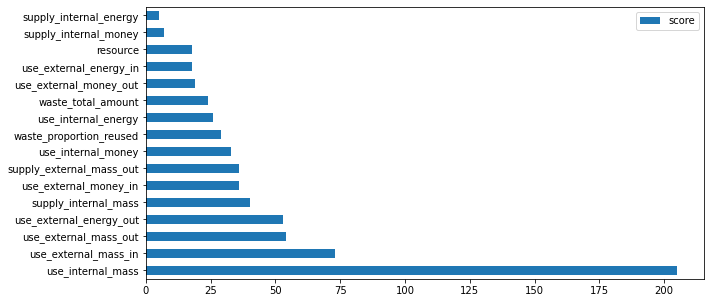

In [211]:
def display_feat_imp_rforest(model):
  feature_imp = model_3_xgboost.get_booster().get_score(importance_type='weight')
  keys = list(feature_imp.keys())
  values = list(feature_imp.values())
  data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
  data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5)) 
 
display_feat_imp_rforest(model_3_xgboost)

On aurait pu chercher à faire un grid-search pour optimiser les hyper-paramètres, mais on remarque en tout cas que la feature la plus importante est use_internal_mass, ce qui paraît cohérent car elle caractérise en grande partie l'intensité des flux de matières (nécessitant donc de l'énergie ou des transformations et générant du CO2) au sein d'un pays.
On remarque également que la variable waste_proportion_reused est peu déterminante, ce qui peut sembler intuitif, le recyclage des déchets étant au premier ordre décorellé des émissions de GES.
Enfin, bien qu'il est certain que de meilleurs indicateurs existent, les scores supérieurs à 0.7 ou 0.8 nous renforcent dans l'idée que ces features permettent de caractériser en partie l'économie d'un pays.
Il aurait cependant été très intéressant d'ajouter des indices commme le PIB ou encore la population afin de vérifier si les features choisies peuvent bien expliquer la richesse d'un pays.

Je me suis arrêté la pour cette brève étude, à noter qu'une infinité d'autres axes auraient pu être exploités (gestion du territoire, part des investissements publics, investissements dans la santé et l'éducation...)

Pour aller plus loin, il serait très intéressant d'exploiter ces bases sur plusieurs années, afin de construire des séries temporelles pour chaque pays, et déterminer , par exemple, les caractéristiques les plus déterminantes pour la croissance d'un pays ou bien sa transition écologique.